In [1]:
#install.packages("anndata")
#devtools::install_github("jinworks/CellChat")

In [2]:
library(anndata)
library(CellChat)
library(patchwork)
library(ggplot2)
options(stringsAsFactors = FALSE)
library(dplyr)
library(stringr)


Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: ggplot2



In [3]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.3 LTS

Matrix products: default
BLAS/LAPACK: /usr/lib/x86_64-linux-gnu/openblas-openmp/libopenblasp-r0.3.8.so;  LAPACK version 3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=C             
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: UTC
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] stringr_1.5.1       patchwork_1.1.3     CellChat_2.1.2     
[4] Biobase_2.62.0      BiocGenerics_0.48.1 ggplot2_3.4.4      
[7] igraph_1.5.1        dplyr_1.1.4         anndata_0.7.5.6    

loaded via a namespace (and not attached):
 

In [4]:
create_OutputFolder <- function(folder_path) {
  if (!file.exists(folder_path)) {
    dir.create(folder_path, recursive = TRUE)
    cat("Folder created:", folder_path, "\n")
  } else {
    cat("Folder already exists:", folder_path, "\n")
  }
}

objects_folder="./output/dataobjects"
create_OutputFolder(objects_folder)


Folder created: ./output/dataobjects 


In [5]:
ad <- read_h5ad("../adata_Xen.h5ad")

In [6]:
ad

AnnData object with n_obs × n_vars = 3218210 × 480
    obs: 'x', 'y', 'z', 'cluster', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence', 'avg_assignment_confidence', 'max_cluster_frac', 'lifespan', 'x_centroid', 'y_centroid', 'cell_area', 'Slide_ID', 'batch', 'Patient_Sample_ID', 'Disease', 'n_genes', 'celltype_l1', 'celltype_l1_codes', 'celltype_l1_prob', 'Biopsy_ID', 'sample', 'label', 'nichepca_domain', 'nichepca_domain_tuned', 'nichepca_glom_no', 'glom_ID', 'polygon_flags', 'is_in_polygon', 'is_in_glom', 'is_in_periglom', 'Slide_num'
    var: 'gene_ids', 'feature_types'
    uns: 'celltype_l1_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'

In [7]:
#Excluding the Tubule cells since we want to focus on the interaction of kidney cells of the Glomerulus and Periglemerular Regions with immune cells, fibroblasts etc. Tubule cells introduce too many cell-cell pairs where there is not much meaningful information in our regions fo interest.
exclude_cells = c('ATL', 'CNT', 'DCT', 'DTL', 'TAL','IC',  'PC', 'PapE','NEU')
ad<-ad[!(ad$obs$celltype_l1 %in% exclude_cells),]

In [8]:
ad

View of AnnData object with n_obs × n_vars = 2565468 × 480
    obs: 'x', 'y', 'z', 'cluster', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence', 'avg_assignment_confidence', 'max_cluster_frac', 'lifespan', 'x_centroid', 'y_centroid', 'cell_area', 'Slide_ID', 'batch', 'Patient_Sample_ID', 'Disease', 'n_genes', 'celltype_l1', 'celltype_l1_codes', 'celltype_l1_prob', 'Biopsy_ID', 'sample', 'label', 'nichepca_domain', 'nichepca_domain_tuned', 'nichepca_glom_no', 'glom_ID', 'polygon_flags', 'is_in_polygon', 'is_in_glom', 'is_in_periglom', 'Slide_num'
    var: 'gene_ids', 'feature_types'
    uns: 'celltype_l1_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'

In [9]:
colnames(ad$obs)

[1] "x"                         "y"                        
 [3] "z"                         "cluster"                  
 [5] "n_transcripts"             "density"                  
 [7] "elongation"                "area"                     
 [9] "avg_confidence"            "avg_assignment_confidence"
[11] "max_cluster_frac"          "lifespan"                 
[13] "x_centroid"                "y_centroid"               
[15] "cell_area"                 "Slide_ID"                 
[17] "batch"                     "Patient_Sample_ID"        
[19] "Disease"                   "n_genes"                  
[21] "celltype_l1"               "celltype_l1_codes"        
[23] "celltype_l1_prob"          "Biopsy_ID"                
[25] "sample"                    "label"                    
[27] "nichepca_domain"           "nichepca_domain_tuned"    
[29] "nichepca_glom_no"          "glom_ID"                  
[31] "polygon_flags"             "is_in_polygon"            
[33] "is_in_glom"                "is_in_periglom"           
[35] "Slide_num"

In [10]:
unique(ad$obs$Slide_ID)

[1] 0011762 0011546 0011216 0011707 0011695 0011284 0011287 0018775
Levels: 0011216 0011284 0011287 0011546 0011695 0011707 0011762 0018775

In [11]:
plot_vals = ad$obs

### Adding offsets to ensure that cells from two different slides are not taken as neighbours (theeir x and y corrodinates without the offsets would be problematic)  

In [12]:
x_axis_offset <- 20000
y_axis_offset <- 0

# Apply the offsets
plot_vals_adjusted <- plot_vals %>%
  mutate(
    Slide_Index = as.numeric(str_extract(Slide_num, "[0-9]+")),  # Extract numeric part of Slide_num
    x_adjusted = x + (Slide_Index - 1) * x_axis_offset,         
    y_adjusted = y + (Slide_Index - 1) * y_axis_offset          
  )


In [13]:
ad$obs = plot_vals_adjusted
head(ad$obs)

,x,y,z,cluster,n_transcripts,density,elongation,area,avg_confidence,avg_assignment_confidence,⋯,nichepca_glom_no,glom_ID,polygon_flags,is_in_polygon,is_in_glom,is_in_periglom,Slide_num,Slide_Index,x_adjusted,y_adjusted
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<fct>,<fct>,<fct>,<lgl>,<lgl>,<lgl>,<fct>,<dbl>,<dbl>,<dbl>
cell_CR4f0dee9aa-1,4221.533,884.8588,30.84282,1,13,0.4426,3.256,29.370,0.9889,0.9415,⋯,Other,Other_0011762_SLE_X8,,FALSE,FALSE,FALSE,Slide1,1,4221.533,884.8588
cell_CR4f0dee9aa-2,4198.106,924.2519,33.60833,1,10,0.8071,1.651,12.390,0.9882,0.9820,⋯,Other,Other_0011762_SLE_X8,,FALSE,FALSE,FALSE,Slide1,1,4198.106,924.2519
cell_CR4f0dee9aa-3,4556.541,577.1648,28.91921,4,14,0.6986,3.840,20.040,0.9293,0.9314,⋯,Other,Other_0011762_SLE_X8,,FALSE,FALSE,FALSE,Slide1,1,4556.541,577.1648
cell_CR4f0dee9aa-4,4218.638,919.6793,31.85209,1,16,1.5040,1.853,10.640,0.9967,0.9988,⋯,Other,Other_0011762_SLE_X8,,FALSE,FALSE,FALSE,Slide1,1,4218.638,919.6793
cell_CR4f0dee9aa-5,4252.774,894.9812,27.87954,2,20,0.6283,3.569,31.830,0.9899,0.9020,⋯,Other,Other_0011762_SLE_X8,,FALSE,FALSE,FALSE,Slide1,1,4252.774,894.9812
cell_CR4f0dee9aa-6,4194.935,957.6134,30.24224,1,9,0.9910,1.373,9.082,0.9735,0.9356,⋯,Other,Other_0011762_SLE_X8,,FALSE,FALSE,FALSE,Slide1,1,4194.935,957.6134


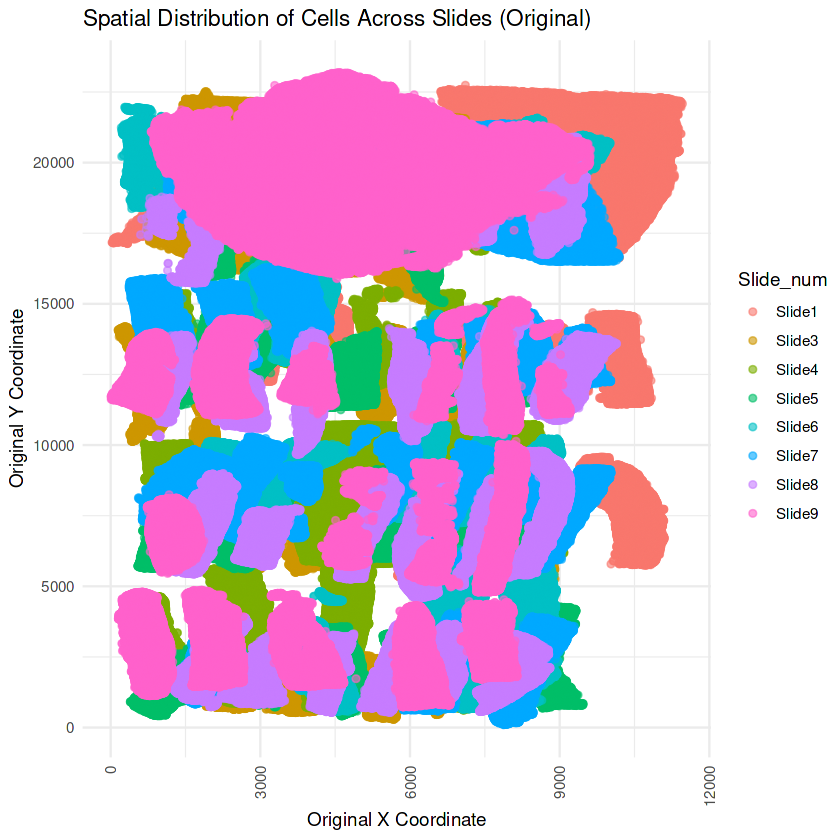

In [14]:
# Original Coordinates plotted

p <- ggplot(plot_vals_adjusted, aes(x = x, y = y)) +
  geom_point(aes(color = Slide_num), size = 1.5, alpha = 0.6) +  
  labs(title = "Spatial Distribution of Cells Across Slides (Original)", 
       x = "Original X Coordinate", 
       y = "Original Y Coordinate") +
  theme_minimal() +
  theme(legend.position = "right",  #
        axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))  

print(p)

ggsave("./output/p_SpatialCoords_Original.png", plot = p, width = 8, height = 8, dpi = 300)

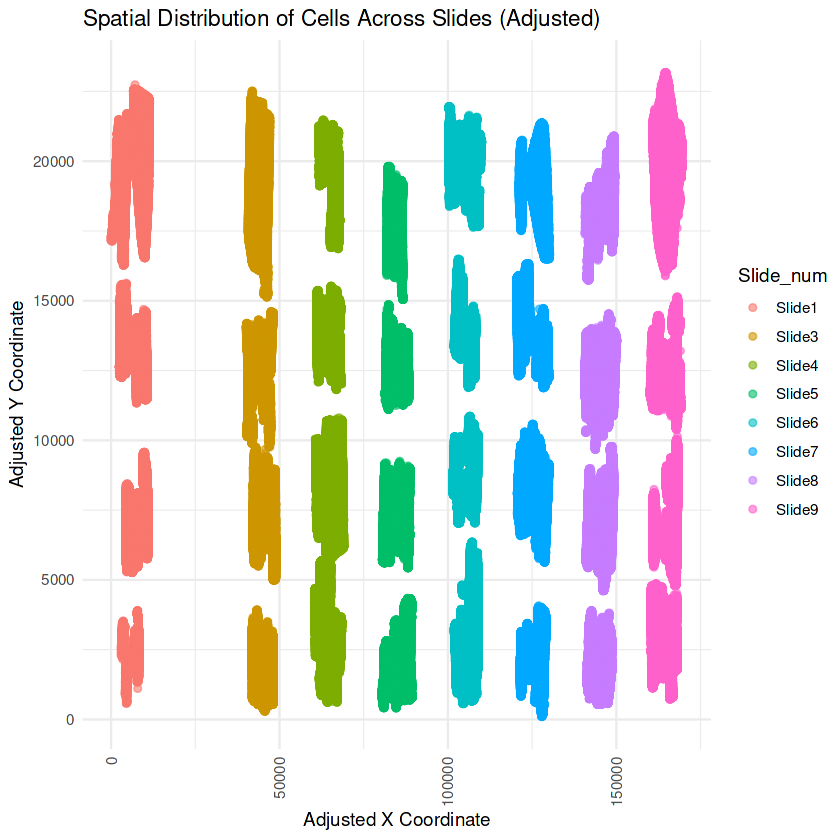

In [15]:
# Adjusted Coordinates plotted

p <- ggplot(plot_vals_adjusted, aes(x = x_adjusted, y = y_adjusted)) +
  geom_point(aes(color = Slide_num), size = 1.5, alpha = 0.6) +  
  labs(title = "Spatial Distribution of Cells Across Slides (Adjusted)", 
       x = "Adjusted X Coordinate", 
       y = "Adjusted Y Coordinate") +
  theme_minimal() +
  theme(legend.position = "right",  #
        axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))  

print(p)

ggsave("./output/p_SpatialCoords_Adjusted.png", plot = p, width = 8, height = 8, dpi = 300)


# CREATE CELL-CHAT OBJECTS

#### Information about Spatial Coordinates of Xenium data 

The Xenium cell feature matrix and transcripts result coordinates are in microns. 
(Ref : https://kb.10xgenomics.com/hc/en-us/articles/11636252598925-What-are-the-Xenium-image-scale-factors)

For single-cell resolution spatial technologies like seqFISH/merFISH/STARmap data, the spatial coordinates are already in micrometers and thus the conversion factor is 1. The spot.size can be the typical human cell size (i.e., 10um).
(Ref: https://htmlpreview.github.io/?https://github.com/jinworks/CellChat/blob/master/tutorial/FAQ_on_applying_CellChat_to_spatial_transcriptomics_data.html)


In [16]:
make_cellchat_spatial <- function(ad) {
  
  counts <- t(as.matrix(ad$X))
  data.input <- as(counts, "dgCMatrix")
  meta <- ad$obs 
  meta$labels <- meta[["celltype_l1"]] 
  meta$samples <- meta[["sample"]]     
     
    spatial.locs = meta[,c('x_adjusted','y_adjusted')]
    
    spatial.factors = data.frame(samples = meta[,'samples'])
    spatial.factors$ratio = 1 # The Xenium cell feature matrix and transcripts result coordinates are in microns.
    spatial.factors$tol = 5 # Tolerance = half the size of a typical human cell 

  
  # Create CellChat object
    # Ref : https://htmlpreview.github.io/?https://github.com/jinworks/CellChat/blob/master/tutorial/CellChat_analysis_of_spatial_transcriptomics_data.html       

    cellchat <- createCellChat(object = data.input, 
                               meta = meta, 
                               group.by = "labels",
                               datatype = "spatial", 
                               coordinates = spatial.locs, 
                               spatial.factors = spatial.factors)    
    
    cellchat <- addMeta(cellchat, meta = meta)
    cellchat <- setIdent(cellchat, ident.use = "labels") # set "labels" as default cell identity
    groupSize <- as.numeric(table(cellchat@idents)) # number of cells in each cell group
    
    return(cellchat)

}

In [17]:
library(presto)

preprocess1_cellchat_spatial <- function(cellchat) {
    
  CellChatDB <- CellChatDB.human
    
    CellChatDB.use <- subsetDB(CellChatDB, search = "Secreted Signaling", key = "annotation") # TO use ONLY Secreted Signaling
  
    cellchat@DB <- CellChatDB.use
  
  cellchat <- subsetData(cellchat) # This step is necessary even if using the whole database
  future::plan("multisession", workers = 4) # do parallel
  
  cellchat <- identifyOverExpressedGenes(cellchat) 
  cellchat <- identifyOverExpressedInteractions(cellchat)
  
  return(cellchat)
}


Loading required package: Rcpp

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last




## Cntrl

In [18]:
ad_Cntrl <- ad[(ad$obs$Disease == "Cntrl" & ad$obs$is_in_polygon == TRUE),]
cellchat = make_cellchat_spatial(ad_Cntrl)
cellchat = preprocess1_cellchat_spatial(cellchat)
saveRDS(cellchat, file=paste0(objects_folder,"/cellchat_Cntrl_adjusted_XY_withDE.rds"))

[1] "Create a CellChat object from a data matrix"
Create a CellChat object from spatial transcriptomics data... 
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  podocyte, PEC, mesangial cell, Transformed mesangial, VSM/P, EC, PT, FIB, T, NKC/T, B, PL, N, MAC, MDC, Mono, MAST, cDC, pDC, cycMNP, cycNKC/T 
The number of highly variable ligand-receptor pairs used for signaling inference is 55 


## cGN

In [19]:
ad_cGN <- ad[(ad$obs$Disease != "Cntrl" & ad$obs$is_in_polygon == TRUE),]
cellchat = make_cellchat_spatial(ad_cGN)
cellchat = preprocess1_cellchat_spatial(cellchat)
saveRDS(cellchat, file=paste0(objects_folder,"/cellchat_cGN_adjusted_XY_withDE.rds"))

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.7 GiB”


[1] "Create a CellChat object from a data matrix"
Create a CellChat object from spatial transcriptomics data... 
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  podocyte, PEC, mesangial cell, Transformed mesangial, VSM/P, EC, PT, FIB, T, NKC/T, B, PL, N, MAC, MDC, Mono, MAST, cDC, pDC, cycMNP, cycNKC/T 
The number of highly variable ligand-receptor pairs used for signaling inference is 57 


## Anca

In [20]:
ad_Anca <- ad[(ad$obs$Disease == "ANCA" & ad$obs$is_in_polygon == TRUE),]
cellchat = make_cellchat_spatial(ad_Anca)
cellchat = preprocess1_cellchat_spatial(cellchat)
saveRDS(cellchat, file=paste0(objects_folder,"/cellchat_Anca_adjusted_XY_withDE.rds"))

[1] "Create a CellChat object from a data matrix"
Create a CellChat object from spatial transcriptomics data... 
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  podocyte, PEC, mesangial cell, Transformed mesangial, VSM/P, EC, PT, FIB, T, NKC/T, B, PL, N, MAC, MDC, Mono, MAST, cDC, pDC, cycMNP, cycNKC/T 
The number of highly variable ligand-receptor pairs used for signaling inference is 57 


## Sle

In [21]:
ad_Sle <- ad[(ad$obs$Disease == "SLE" & ad$obs$is_in_polygon == TRUE),]
cellchat = make_cellchat_spatial(ad_Sle)
cellchat = preprocess1_cellchat_spatial(cellchat)
saveRDS(cellchat, file=paste0(objects_folder,"/cellchat_Sle_adjusted_XY_withDE.rds"))

[1] "Create a CellChat object from a data matrix"
Create a CellChat object from spatial transcriptomics data... 
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  podocyte, PEC, mesangial cell, Transformed mesangial, VSM/P, EC, PT, FIB, T, NKC/T, B, PL, N, MAC, MDC, Mono, MAST, cDC, pDC, cycMNP, cycNKC/T 
The number of highly variable ligand-receptor pairs used for signaling inference is 56 


## Gbm

In [22]:
ad_Gbm <- ad[(ad$obs$Disease == "GBM" & ad$obs$is_in_polygon == TRUE),]
cellchat = make_cellchat_spatial(ad_Gbm)
cellchat = preprocess1_cellchat_spatial(cellchat)
saveRDS(cellchat, file=paste0(objects_folder,"/cellchat_Gbm_adjusted_XY_withDE.rds"))

[1] "Create a CellChat object from a data matrix"
Create a CellChat object from spatial transcriptomics data... 
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  podocyte, PEC, mesangial cell, Transformed mesangial, VSM/P, EC, PT, FIB, T, NKC/T, B, PL, N, MAC, MDC, Mono, MAST, cDC, pDC, cycMNP, cycNKC/T 
The number of highly variable ligand-receptor pairs used for signaling inference is 57 


In [23]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.3 LTS

Matrix products: default
BLAS/LAPACK: /usr/lib/x86_64-linux-gnu/openblas-openmp/libopenblasp-r0.3.8.so;  LAPACK version 3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=C             
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: UTC
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] presto_1.0.0        data.table_1.14.8   Rcpp_1.0.11        
 [4] stringr_1.5.1       patchwork_1.1.3     CellChat_2.1.2     
 [7] Biobase_2.62.0      BiocGenerics_0.48.1 ggplot2_3.4.4      
[10] igraph_1.5.1        dplyr_1.1.4      